In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

Task: To predict whether the user likes the mobile phone or not. <br>
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

<b>Missing values:</b><br>
'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447)
'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467),
'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473),
'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456),
'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

<b>Very low variance:</b><br>
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'


<b>Multivalued:</b><br>
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

<b>Not important:</b><br>
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

<b>Doubtful:</b><br>
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing),
'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'
    
<b>To check:</b><br>
'Display Type','Expandable Memory','FM Radio'

<b>High Correlation with other features</b><br>
'SIM Slot(s)' high correlation with SIM1
'Weight' has high high correlation with capacity , screen-to-body ratio
'Height' - screen size is also there
    
<b>Given a mobile, we can't directly get these features</b><br>
'Rating Count', 'Review Count'

<b>Keeping:</b><br>
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',


In [2]:
# read data from file
train = pd.read_csv("../input/train.csv") 
test = pd.read_csv("../input/test.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [3]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing features

In [4]:
train = data_clean(train)
test = data_clean(test)

removing all those data points in which more than 15 features are missing 

In [5]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [6]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


# Filling Missing values

In [7]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [8]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_integer)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [9]:
train = data_clean_2(train)
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


Not very important feature

In [10]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [11]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [12]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Height', 'Num_cores', 'Resolution', 'Screen Size',
       'Processor_frequency', 'SIM Slot(s)', 'RAM', 'SIM 2', 'Pixel Density',
       'os_name', 'Brand', 'Capacity', 'Sim1', 'Weight', 'Internal Memory',
       'Screen to Body Ratio (calculated)'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'Height', 'Resolution', 'Screen Size', 'Processor_frequency',
       'RAM', 'Pixel Density', 'Capacity', 'Weight', 'Internal Memory',
       'Screen to Body Ratio (calculated)', 'Num_cores_312', 'Num_cores_Deca',
       'Num_cores_Dual', 'Num_cores_Hexa', 'Num_cores_Octa', 'Num_cores_Other',
       'Num_cores_Quad', 'Num_cores_Tru-Octa',
       'SIM Slot(s)_Dual SIM, GSM+CDMA', 'SIM Slot(s)_Dual SIM, GSM+GSM',
       'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE',
       'SIM Slot(s)_Single SIM, GSM', 'SIM 2_2G', 'SIM 2_3G', 'SIM 2_4G',
       'SIM 2_Other', 'os_name_Android', 'os_name_Blackberry', 'os_name_KAI',
       'os_name_Nokia', 'os_name_Other', 'os_name_Tiz

In [13]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [14]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


In [15]:
train_new.head()

,PhoneId,Height,Resolution,Screen Size,Processor_frequency,RAM,Pixel Density,Capacity,Weight,Internal Memory,Screen to Body Ratio (calculated),Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,...,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Sim1_2G,Sim1_3G,Sim1_4G,Rating
0,0,157.9,20,6.26,1.8,4,403,4000,182,64,80.68,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,4.5
1,1,156.2,8,6.20,1.8,3,271,4230,168,32,80.85,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.5
2,2,157.0,25,6.30,2.1,3,409,3500,168,32,83.68,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.4
3,4,159.8,24,6.00,2.2,4,411,3300,169,64,74.78,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,4.3
4,5,160.4,16,6.50,2.2,4,396,3750,175,64,84.23,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.4


In [16]:
test_new.head()

,PhoneId,Height,Resolution,Screen Size,Processor_frequency,RAM,Pixel Density,Capacity,Weight,Internal Memory,Screen to Body Ratio (calculated),Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,...,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Sim1_2G,Sim1_3G,Sim1_4G
0,3,156.2,5,6.20,1.8,2,271,4230,168,16,80.85,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,11,156.0,12,6.20,1.8,4,402,5000,205,64,81.60,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,13,156.7,25,6.30,2.0,6,409,3500,169,64,83.84,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,16,156.7,16,6.30,2.0,4,409,3500,169,64,83.84,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,19,158.6,20,5.99,1.8,4,403,4000,181,64,77.43,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


## Dummy Solution

In [17]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':[0]*test_new.shape[0]})
submission = submission[['PhoneId', 'Class']]
submission.head()

,PhoneId,Class
0,3,0
1,11,0
2,13,0
3,16,0
4,19,0


In [18]:
submission.to_csv("submission.csv", index=False)

In [19]:
"""
WRITE YOUR MODELLING CODE HERE
"""

'\nWRITE YOUR MODELLING CODE HERE\n'

# Loading Dataset

In [20]:
'''
Step 1:
    1. Create copies of training and test set for column manipulation
    2. Binarize Rating Column using 4 as the Threshold
    3. Map function to RAM column to remove outliers
'''
train_new1 = train_new.copy()
test_new1 = test_new.copy()

In [21]:
train_new1['Rating'] = train_new1['Rating'].map(lambda x: 1 if x >= 4 else 0)

In [22]:
train_new1['RAM'] = train_new1['RAM'].map(lambda x: 0.5 if x == 512 else x)
test_new1['RAM'] = test_new1['RAM'].map(lambda x: 0.5 if x == 512 else x)

In [23]:
train_new1.sort_values('RAM').head(10)
train_new1.columns

Index(['PhoneId', 'Height', 'Resolution', 'Screen Size', 'Processor_frequency',
       'RAM', 'Pixel Density', 'Capacity', 'Weight', 'Internal Memory',
       'Screen to Body Ratio (calculated)', 'Num_cores_312', 'Num_cores_Deca',
       'Num_cores_Dual', 'Num_cores_Hexa', 'Num_cores_Octa', 'Num_cores_Other',
       'Num_cores_Quad', 'Num_cores_Tru-Octa',
       'SIM Slot(s)_Dual SIM, GSM+CDMA', 'SIM Slot(s)_Dual SIM, GSM+GSM',
       'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE',
       'SIM Slot(s)_Single SIM, GSM', 'SIM 2_2G', 'SIM 2_3G', 'SIM 2_4G',
       'SIM 2_Other', 'os_name_Android', 'os_name_Blackberry', 'os_name_KAI',
       'os_name_Nokia', 'os_name_Other', 'os_name_Tizen', 'os_name_iOS',
       'Brand_10.or', 'Brand_Apple', 'Brand_Asus', 'Brand_Billion',
       'Brand_Blackberry', 'Brand_Comio', 'Brand_Coolpad', 'Brand_Do',
       'Brand_Gionee', 'Brand_Google', 'Brand_HTC', 'Brand_Honor',
       'Brand_Huawei', 'Brand_InFocus', 'Brand_Infinix', 'Brand_Intex',
       'Brand

In [24]:
test_new1.sort_values('Internal Memory', ascending=False)

,PhoneId,Height,Resolution,Screen Size,Processor_frequency,RAM,Pixel Density,Capacity,Weight,Internal Memory,Screen to Body Ratio (calculated),Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,...,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Sim1_2G,Sim1_3G,Sim1_4G
69,284,157.500000,16,6.41,2.80,8.0,402,3700,185,256,85.43,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
78,320,153.000000,8,6.20,2.80,8.0,402,3300,155,256,83.64,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
115,467,158.100000,8,6.20,2.70,6.0,531,3500,189,256,83.99,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
54,223,155.500000,20,6.18,2.80,8.0,403,4000,182,256,82.20,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
25,117,158.800000,8,6.00,2.96,8.0,402,4000,200,128,76.78,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
24,112,149.600000,24,5.84,2.36,6.0,432,3400,153,128,79.52,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
72,294,155.700000,16,6.28,2.80,8.0,402,3300,177,128,83.55,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
88,345,153.000000,8,6.20,2.80,6.0,402,3300,155,128,83.64,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
66,266,149.200000,16,5.84,2.36,4.0,432,3000,152,128,79.07,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
108,432,153.900000,16,5.50,2.45,6.0,534,3000,169,128,71.23,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [25]:
list(train_new1.iloc[:,11:].sum().sort_values().index)

['Brand_Do',
 'Brand_Billion',
 'Brand_Spice',
 'Num_cores_312',
 'os_name_Nokia',
 'Brand_Lyf',
 'Brand_Lephone',
 'Brand_Nubia',
 'Brand_LeEco',
 'Brand_Comio',
 'Brand_Razer',
 'Brand_Reliance',
 'SIM Slot(s)_Dual SIM, GSM+CDMA',
 'Num_cores_Tru-Octa',
 'Brand_Ulefone',
 'Brand_VOTO',
 'Brand_iVooMi',
 'Brand_Jivi',
 'os_name_Tizen',
 'Brand_10.or',
 'Brand_Karbonn',
 'Brand_Coolpad',
 'os_name_Blackberry',
 'os_name_KAI',
 'Brand_Motorola',
 'Num_cores_Deca',
 'Brand_Meizu',
 'Brand_Infinix',
 'Brand_OnePlus',
 'Brand_Xiaomi Poco',
 'Brand_InFocus',
 'Brand_Mobiistar',
 'Brand_Panasonic',
 'Brand_Realme',
 'Brand_Yu',
 'Brand_Itel',
 'Brand_Intex',
 'Brand_Google',
 'Brand_Blackberry',
 'Num_cores_Other',
 'Brand_Huawei',
 'Brand_HTC',
 'Brand_Lava',
 'Brand_Oppo',
 'Sim1_2G',
 'os_name_Other',
 'SIM 2_3G',
 'Sim1_3G',
 'Brand_Tecno',
 'Brand_Asus',
 'Brand_LG',
 'Brand_Sony',
 'Brand_Gionee',
 'Num_cores_Dual',
 'Num_cores_Hexa',
 'Brand_OPPO',
 'Brand_Lenovo',
 'Brand_Micromax',


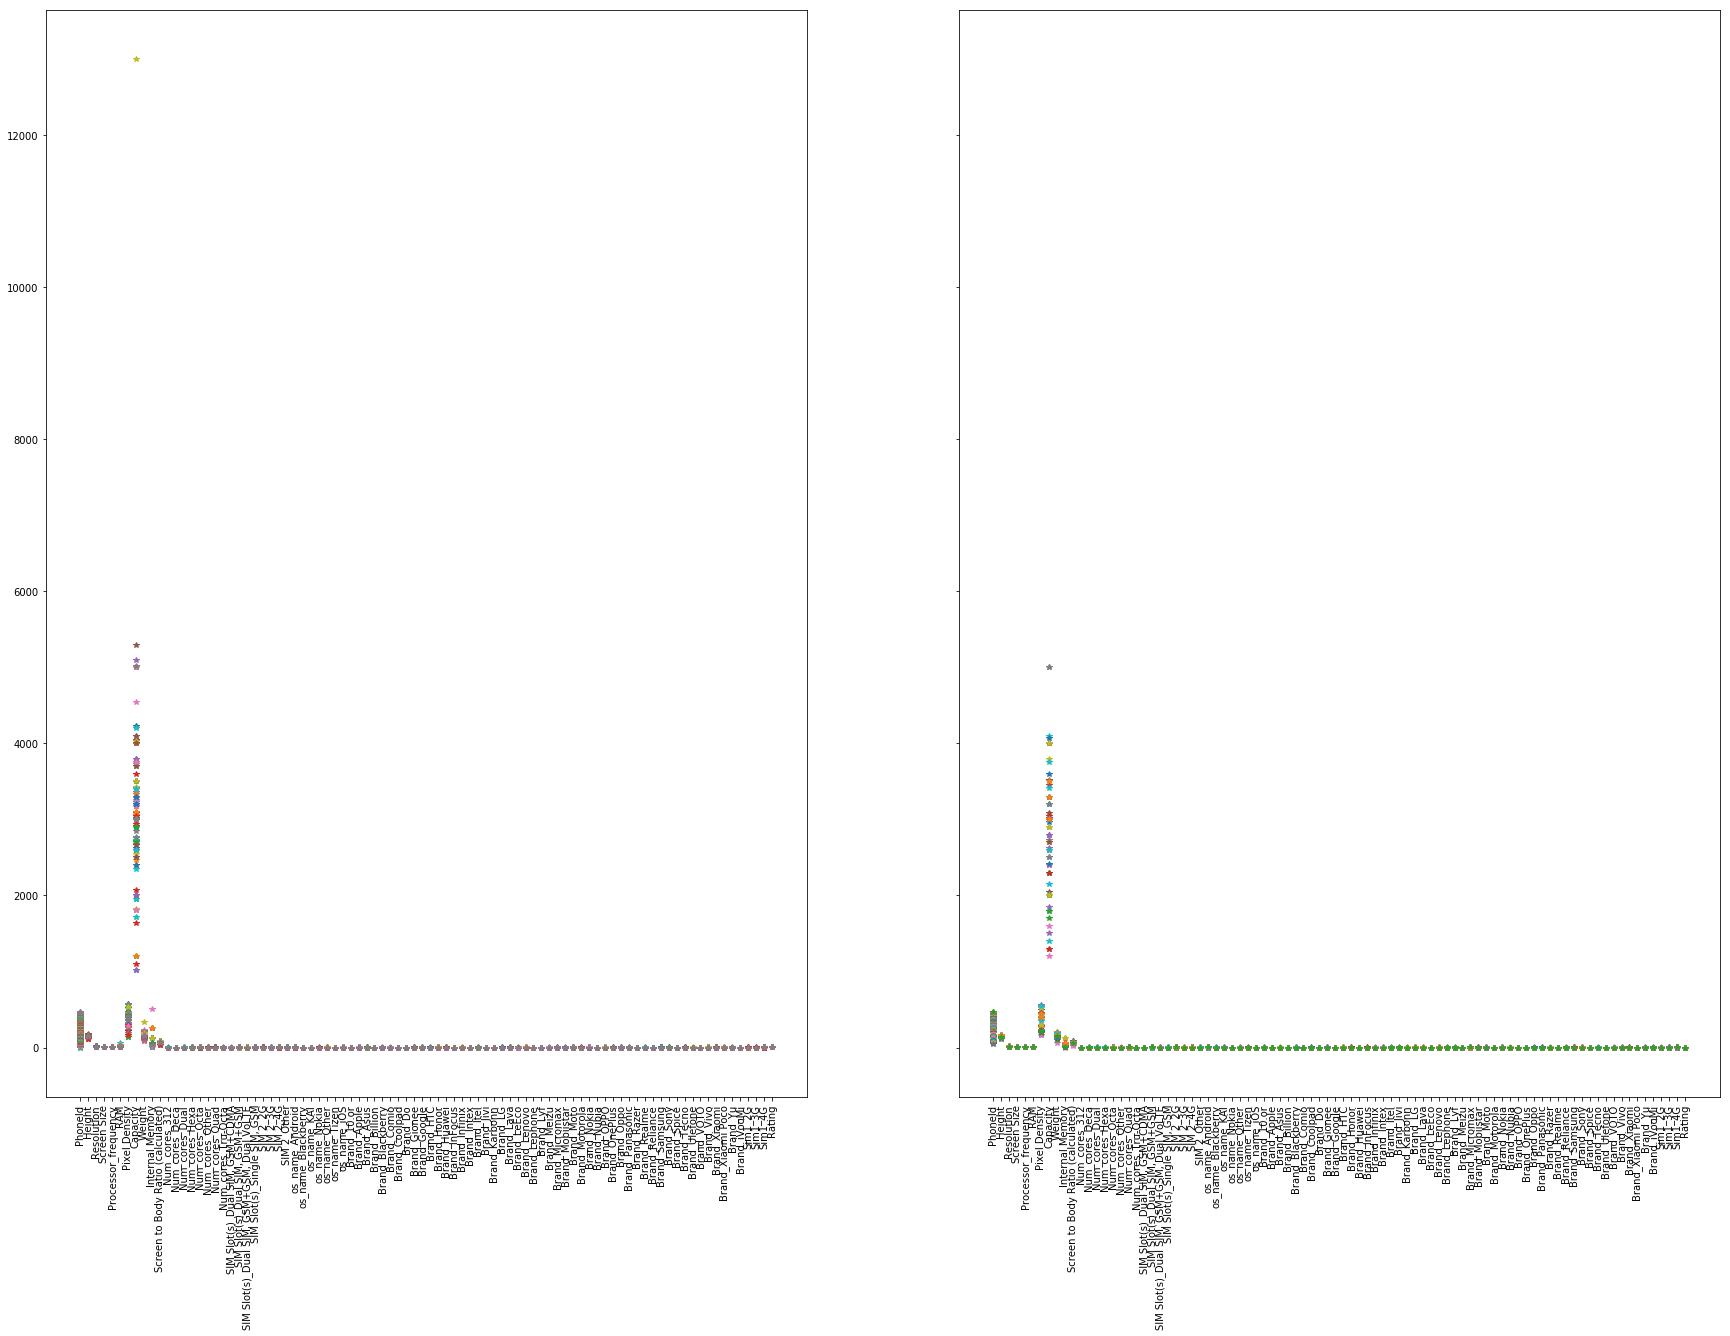

In [26]:
#Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(30,20))
ax1.tick_params(axis='x', rotation=90)
ax1.plot(train_new1[train_new1['Rating'] == 1].T, '*')
ax2.plot(train_new1[train_new1['Rating'] == 0].T, '*')
ax2.tick_params(axis='x', rotation=90)
plt.show()

In [27]:
from sklearn.feature_selection import SelectKBest

In [28]:
low_mean_cols = ['Brand_Nubia',
 'os_name_Nokia',
 'Brand_Razer',
 'Brand_Google',
 'Brand_Infinix',
 'Brand_Reliance',
 'Brand_Jivi',
 'Brand_Meizu',
 'Brand_Huawei',
 'Brand_Mobiistar',
 'Brand_Coolpad',
 'Brand_Panasonic',
 'Brand_Do',
 'Brand_LeEco',
 'Brand_Apple',
 'Brand_Lava',
 'Brand_Micromax',
 'Brand_Comio',
 'Brand_Nokia',
 'Brand_Blackberry',
 'Num_cores_312',
 'Brand_Oppo',
 'SIM Slot(s)_Dual SIM, GSM+CDMA',
 'Brand_Billion',
 'Brand_Tecno',
 'Brand_Vivo',
 'Brand_OnePlus',
 'Brand_Lephone',
 'Brand_iVooMi',
 'Brand_Gionee',
 'Brand_Lyf',
 'Brand_Honor',
 'Brand_10.or',
 'Brand_Sony',
 'Brand_OPPO',
 'Brand_Asus',
 'Brand_Realme',
 'Brand_Ulefone',
 'Brand_Yu',
 'Brand_Samsung',
 'Num_cores_Tru-Octa',
 'Brand_Intex',
 'Brand_Itel',
 'Brand_Spice',
 'Brand_Lenovo',
 'Brand_HTC',
 'Brand_Xiaomi',
 'Brand_InFocus',
 'os_name_Tizen',
 'Brand_Moto',
 'Brand_Motorola',
 'Brand_LG',
 'Brand_Karbonn',
 'Brand_Xiaomi Poco',
 'Brand_VOTO']

In [29]:
'''
Step 2:
    1. When train_new1.groupby('RAM').sum was performed, certain columns were found to contribute very little to the output
    2. These columns were removed
    3. This step was more intuitive
    4. In hindsight, sklearn.feature_selection.SelectKBest could have proved to be useful
    5. The 'extra' columns were used during trial and error selection of unnecessary features.
'''

low_sum_cols = ['Brand_Spice',
 'Brand_Billion',
 'Brand_Do',
 'Brand_Lyf',
 'Brand_Lephone',
 'Brand_VOTO',
 'Brand_LeEco',
 'Brand_Jivi',
 'Brand_Reliance',
 'Brand_Razer',
 'Brand_iVooMi',
 'Brand_Ulefone',
 'Brand_Nubia',
 'Num_cores_312',
 'Brand_Comio',
 'os_name_Tizen',
 'SIM Slot(s)_Dual SIM, GSM+CDMA',
 'os_name_Nokia',
 'Num_cores_Tru-Octa',
 'Num_cores_Deca',
 'Brand_Meizu',
 'os_name_KAI',
 'Brand_10.or',
 'Brand_Karbonn',
 'Brand_Coolpad',
 'Brand_Motorola',
 'os_name_Blackberry',
 'Brand_Xiaomi Poco',
 'Brand_OnePlus',
 'Brand_Infinix',
 'Brand_InFocus',
 'Brand_Realme',
 'Brand_Intex',
 'Brand_Yu',
 'Brand_Itel',
 'Brand_Google',
 'Brand_Mobiistar',
 'Brand_Panasonic',
 'Brand_Blackberry']

In [30]:
'''
Step 3
    1. Here we create the new training and test sets.
    2. There are two training sets here, one where we drop the low_sum_columns and one where they remain
        i. X_train_ram is the one without dropped columns
       ii. X_train_drop has the low_sum_columns removed
'''

# X_train = train_new.drop(['PhoneId', 'Rating', 'Brand_Billion', 'Brand_Do', 'Brand_Spice'], axis=1)
X_train_ram = train_new1.drop(['PhoneId', 'Rating'], axis=1)
y_train = train_new['Rating'].map(lambda x: 1 if x >= 4 else 0)
X_train_drop = X_train_ram.drop(low_sum_cols, axis=1)

# X_test = test_new.drop(['PhoneId', 'Brand_Billion', 'Brand_Do', 'Brand_Spice'], axis=1)
X_test_ram = test_new1.drop(['PhoneId'], axis=1)
X_test_drop = X_test_ram.drop(low_sum_cols, axis=1)

In [31]:
from sklearn.feature_selection import SelectKBest



train_ram_compare = pd.DataFrame({'Mean Values': X_train_ram.mean()})
train_ram_compare.sort_values("Mean Values").head(16)

import sklearn.preprocessing as skpp
sc_Xss = skpp.StandardScaler()
sc_Xmm = skpp.MinMaxScaler()

# Applying mean-normalization to the dataset
X_norm_train = pd.DataFrame(sc_Xss.fit_transform(X_train_ram), columns=X_train_ram.columns)
X_norm_test = pd.DataFrame(sc_Xss.transform(X_test), columns=X_test.columns)

# Applying Min-Max scaler to the dataset
X_mm_train = pd.DataFrame(sc_Xmm.fit_transform(X_train_ram), columns=X_train_ram.columns)
X_mm_test = pd.DataFrame(sc_Xmm.fit_transform(X_test_ram), columns=X_train_ram.columns)

# Binarisation

In [32]:
# Binarisation on non-scaled dataset
X_bin_train1 = X_train_ram.apply(pd.cut, bins=2, labels=[0,1]).values
X_bin_test1 = X_train_ram.apply(pd.cut, bins=2, labels=[0,1]).values

# # Binarisation on Min-Max-scaled dataset
# X_bin_train2 = X_train_ram.apply(pd.cut, bins=2, labels=[0,1])
# X_bin_test2 = X_test_ram.apply(pd.cut, bins=2, labels=[0,1]).values

# Binarisation on the dropped cols dataset
X_bin_train2 = X_train_drop.apply(pd.cut, bins=2, labels=[0,1]).values
X_bin_test2 = X_test_drop.apply(pd.cut, bins=2, labels=[0,1]).values

X_train_compare = pd.DataFrame({'Without scale': X_bin_train1.mean(), 'With MM': X_bin_train2.mean()})
X_train_compare.head()

X_train_compare.sort_values('With MM')

# MP Neuron Class

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [34]:
class MPNeuron():
    
    def __init__(self):
        self.b = None
        
    def model(self, x):
        return 1 if (sum(x) >= self.b) else 0
    
    def predict(self, X):
        y = []
        for x in X:
            y_pred = self.model(x)
            y.append(y_pred)
        return np.array(y)
    
    def fit(self, X, y):
        accuracy = {}
        
        for b in range(X.shape[1] + 1):
            self.b = b
            y_pred = self.predict(X)
            accuracy[b] = accuracy_score(y_pred, y)
            
        best_b = max(accuracy, key=accuracy.get)
        self.b = best_b
        print(f'The best b value is {best_b} with an accuracy of {accuracy[best_b]*100:0.2f}%')
        plt.plot(accuracy.keys(), accuracy.values())
#         plt.xticks(accuracy.keys())
        plt.show()

In [35]:
mpneuron1 = MPNeuron()
mpneuron2 = MPNeuron()


The best b value is 8 with an accuracy of 70.67%


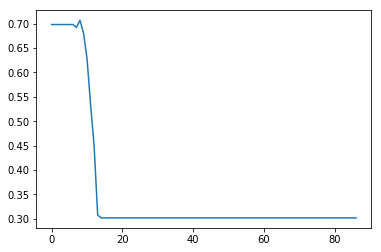

The best b value is 9 with an accuracy of 70.97%


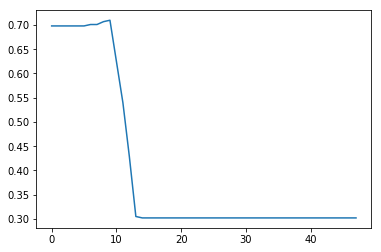

In [36]:
mpneuron1.fit(X_bin_train1, y_train)
mpneuron2.fit(X_bin_train2, y_train)

In [37]:
type(X_bin_train1)

numpy.ndarray

In [38]:
y_pred = mpneuron2.predict(X_bin_test2)
submission = pd.DataFrame({'PhoneId': test_new1['PhoneId'], 'Class': y_pred})
submission = submission[['PhoneId', 'Class']]


In [39]:
submission.to_csv('MP_Neuron3.csv', index=False)

In [40]:
list(submission.Class)

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1]